In [113]:
# import
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import math
import glob
import time
from sklearn.utils import resample

In [114]:
def retrieve_data(verbose=True):
    data_files = glob.glob('../data/*.txt')
    data = np.array([])
    for data_file in data_files:
        data = np.hstack((data,np.loadtxt(data_file, dtype = str)))

    '''
    features = ['kills', 'deaths', 'assists', 'last_hits', 'denies',\
                'gold_per_min', 'xp_per_min',\
                'hero_damage', 'tower_damage',\
                'radiant_win']
    '''

    feature_num = 91
    data_int = []
    for i in data:
        if i == 'true':
            data_int.append(1)
        elif i == 'false':
            data_int.append(-1)
        else: 
            data_int.append(int(i))

    data_array = np.asarray(data_int)
    data_size = data_array.shape[0]
    data_matrix = data_array.reshape((data_size/feature_num, feature_num))

    X = data_matrix[:,0:-1]
    y = data_matrix[:,-1]
    y = np.expand_dims(y, axis=1)
    
    if verbose:
        print X.shape, y.shape

    rad_hero_damage_idx = [i for i in range(7, 45, 9)]
    dir_hero_damage_idx = [i for i in range(7 + 1, 45, 9)]
    rad_tower_damage_idx = [i for i in range(7 + 45, 90, 9)]
    dir_tower_damage_idx = [i for i in range(7 + 1 + 45, 90, 9)]
    
    del_idx = rad_hero_damage_idx + dir_hero_damage_idx + rad_tower_damage_idx + dir_tower_damage_idx
    
    X = np.delete(X, del_idx, axis=1)
    
#     sum_idxs = [rad_hero_damage_idx, dir_hero_damage_idx, rad_tower_damage_idx, dir_tower_damage_idx]
#     for sum_idx in sum_idxs:
#         s = np.sum(X[:,sum_idx],axis=1)[:,np.newaxis]
#         Z = np.hstack((Z,s))

    if verbose:
        print X.shape, y.shape
        
    return X, y

In [115]:
# K_Fold
def K_Fold(n, n_folds=10, shuffle=False):
    step = n // n_folds
    remainder = n % n_folds
    
    # generate fold sizes
    fold_sizes = (step) * np.ones(n_folds, dtype=np.int)
    fold_sizes[:remainder] += 1
    
    train_idx = []
    test_idx = []
    
    sequence = np.array(range(n))
    if shuffle:
        np.random.shuffle(sequence)
        
    cursor = 0
    for fs in fold_sizes:
        test_fold = sequence[cursor:cursor + fs]
        test_idx.append(test_fold)
        train_fold = np.delete(sequence, range(cursor, cursor + fs))
        train_idx.append(train_fold)
        cursor += fs
    return train_idx, test_idx

In [116]:
class decision_node:
    def __init__(self, feature_idx=-1., threshold=-1., result=0., left_node=None, right_node=None):
        self.feature_idx=feature_idx # feature index of criteria being tested
        self.threshold=threshold # threshold necessary to get a true result
        self.result=result # dict of results for a branch, None for everything except endpoints
        self.left_node=left_node # left decision nodes (<=)
        self.right_node=right_node # false decision nodes {>}

In [117]:
def calculate_threshold(X, y):
    threshold = -1. * np.ones([X.shape[1], 1])
    for i in range(X.shape[1]):
        # sort
        u = np.sort(np.unique(X[:, i]))
        
        # for every two ajacent values, generate a threshold to calculate classification error
        th = -1. * np.ones([u.shape[0] - 1, 1])
        for j in range(u.shape[0] - 1):
            th[j] = (u[j] + u[j + 1]) / 2.
        
        # calculate classification error
        cls_error = 2. * np.ones([th.shape[0], 1])
        for j in range(th.shape[0]):
            y_l = y[X[:, i] <= th[j]]
            y_r = y[X[:, i] > th[j]]

            # calculate the classification error
            error_l = min(y_l[y_l <= 0].shape[0], y_l[y_l > 0].shape[0])
            error_r = min(y_r[y_r <= 0].shape[0], y_r[y_r > 0].shape[0])
            cls_error[j] = 1. * (error_l + error_r) / y.shape[0]
        
        threshold[i] = th[np.argmin(cls_error, axis=0)]
        
    return threshold

In [118]:
def fit(X, y, feature_list, min_amt=0, max_depth=0):
    threshold = calculate_threshold(X, y)
    root = decision_tree(X, y, 0, feature_list, threshold, min_amt=min_amt, max_depth=max_depth)
    return root

In [119]:
def decision_tree(X, y, depth, feature_list, threshold, min_amt=0, max_depth=0):
    # bottom up condition
    if (max_depth > 0 and depth == max_depth) or y.shape[0] <= min_amt:
        if y[y <= 0].shape[0] > y[y > 0].shape[0]:
            leaf = decision_node(result=-1.)
            return leaf
        
        leaf = decision_node(result=1.)
        return leaf
    elif np.unique(y).shape[0] == 1:
        return decision_node(result=np.unique(y))
    elif len(feature_list) == 1:
        left_node = decision_node(result=-1.)
        right_node = decision_node(result=1.)
        root = decision_node(feature_idx=feature_list[0], threshold=threshold[feature_list[0]], \
                         left_node=left_node, right_node=right_node)
        return root
    
    # 1. calculate classification error
    cls_feture_list = list(feature_list)
    cls_error = classification_error(X, y, cls_feture_list, threshold)
    
    feature_idx = np.argmin(cls_error, axis=0)
    feature_list.remove(int(feature_idx[0]))
    remain_feature_list = list(feature_list)
    
    # 2. create left tree
    left_node = decision_tree(X[X[:, feature_idx[0]] <= threshold[feature_idx[0]]], \
                              y[X[:, feature_idx[0]] <= threshold[feature_idx[0]]], \
                              depth + 1, remain_feature_list, threshold, min_amt=min_amt, max_depth=max_depth)
    
    # 3. create right tree
    right_node = decision_tree(X[X[:, feature_idx[0]] > threshold[feature_idx[0]]], \
                               y[X[:, feature_idx[0]] > threshold[feature_idx[0]]], \
                               depth + 1, remain_feature_list, threshold, min_amt=min_amt, max_depth=max_depth)
    
    if left_node.result != 0. and right_node.result != 0. and left_node.result == right_node.result:
        # left node and right node are both leaf nodes and have the same result,
        # these two can be combined to one leaf node with that result
        leaf = decision_node(result=left_node.result)
    
    # 4. create root node
    root = decision_node(feature_idx=feature_idx[0], threshold=threshold[feature_idx[0]], \
                         left_node=left_node, right_node=right_node)
    
    return root

In [120]:
def classification_error(X, y, feature_list, threshold):
    th = threshold[feature_list]
    X_s = X[:, feature_list]
    
    cls_error = 2. * np.ones([threshold.shape[0], 1])
    for i in range(th.shape[0]):
        y_l = y[X_s[:, i] <= th[i]]
        y_r = y[X_s[:, i] > th[i]]
        
        # calculate the classification error
        error_l = min(y_l[y_l <= 0].shape[0], y_l[y_l > 0].shape[0])
        error_r = min(y_r[y_r <= 0].shape[0], y_r[y_r > 0].shape[0])
        cls_error[feature_list[i]] = 1. * (error_l + error_r) / y.shape[0]
        
    return cls_error

In [121]:
def print_decision_tree(root, depth):
    if root.result != 0.:
        print_decision_node(root, depth)
        return
    
    print_decision_tree(root.right_node, depth + 1)
    print_decision_node(root, depth)
    print_decision_tree(root.left_node, depth + 1)

In [122]:
def print_decision_node(node, depth):
    if node.result != 0.:
        if depth > 0:
            for i in range(depth):
                print '\t',
        print 'depth = %d (LEAF result = %d)' % (depth, int(node.result))
    else:
        if depth > 0:
            for i in range(depth):
                print '\t',
        print 'depth = %d (fid=%d, th=%.1f)' % (depth, int(node.feature_idx), node.threshold)

In [123]:
def predict(X, root):
    # bottom up condition: root is a leaf
    if root.result != 0.:
        return root.result
    
    # go into left node if <= threshold
    if X[root.feature_idx] <= root.threshold:
        return predict(X, root.left_node)

    return predict(X, root.right_node)

In [124]:
def score(X, y):
    X_s = (X + 1.) / 2.
    y_s = (y + 1.) / 2.
    c_matrix = np.zeros((2, 2))
    for j in range(X_s.shape[0]):
        c_matrix[int(y_s[j])][int(X_s[j])] += 1
    
    total = np.sum(c_matrix)
    total_accuracy = 1. * np.sum(c_matrix[i][i] for i in range(c_matrix.shape[0])) / total
    accuracy = []
    precision = []
    recall = []
    F1 = []
    
    for i in range(c_matrix.shape[0]):
        tp = c_matrix[i][i]
        fp = np.sum(c_matrix[:, i]) - tp
        fn = np.sum(c_matrix[i]) - tp
        tn = total - tp - fp - fn
        
        accuracy.append(1. * (tp + tn) / total)
        p = 1. * tp / (tp + fp)
        precision.append(p)
        r = 1. * tp / (tp + fn)
        recall.append(r)
        F1.append(2. * (p * r / (p + r)))
    return c_matrix, total_accuracy, accuracy, precision, recall, F1

In [125]:
def print_c_matrix(c_matrix):
    for i in range(c_matrix.shape[0]):
        for j in range(c_matrix.shape[1]):
            suffix = '&'
            if j == c_matrix.shape[1] - 1:
                suffix = '\\\\'
            print '%d' % int(c_matrix[i, j]), suffix,
        print ''
    print ''

In [126]:
def print_avg(avg):
    for i in range(avg.shape[0]):
        suffix = '&'
        if i == avg.shape[0] - 1:
            suffix = '\\\\'
        print '%.3f' % avg[i], suffix,
    print ''

In [127]:
# cross validation
def cross_validation(X, y, min_amt=0, max_depth=0, n_folds=5, r_verbose=False):
    train_c_matrix = []
    train_total_accuracy = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_F1 = []
    
    test_c_matrix = []
    test_total_accuracy = []
    test_accuracy = []
    test_precision = []
    test_recall = []
    test_F1 = []
    
    train_idx, test_idx = K_Fold(y.shape[0], n_folds=n_folds, shuffle=True)
    
    for i in range(n_folds):
        X_train = X[train_idx[i]]
        X_test = X[test_idx[i]]
        
        # fit
        feature_list = range(X.shape[1])
        root = fit(X, y, feature_list, min_amt=min_amt, max_depth=max_depth)

        # training & test error
        train_predicted = np.apply_along_axis(predict, 1, X_train, root)
        tr_c_matrix, tr_total_accuracy, tr_accuracy, tr_precision, tr_recall, tr_F1 = \
        score(train_predicted, y[train_idx[i]])
        
        test_predicted = np.apply_along_axis(predict, 1, X_test, root)
        t_c_matrix, t_total_accuracy, t_accuracy, t_precision, t_recall, t_F1 = \
        score(test_predicted, y[test_idx[i]])
        
        train_c_matrix.append(tr_c_matrix)
        train_total_accuracy.append(tr_total_accuracy)
        train_accuracy.append(tr_accuracy)
        train_precision.append(tr_precision)
        train_recall.append(tr_recall)
        train_F1.append(tr_F1)
        
        test_c_matrix.append(t_c_matrix)
        test_total_accuracy.append(t_total_accuracy)
        test_accuracy.append(t_accuracy)
        test_precision.append(t_precision)
        test_recall.append(t_recall)
        test_F1.append(t_F1)
        
    train_accuracy = np.array(train_accuracy).T
    train_precision = np.array(train_accuracy).T
    train_recall = np.array(train_recall).T
    train_F1 = np.array(train_F1).T
    
    test_accuracy = np.array(test_accuracy).T
    test_precision = np.array(test_accuracy).T
    test_recall = np.array(test_recall).T
    test_F1 = np.array(test_F1).T

    # average error
    train_total_accuracy_avg = np.mean(train_total_accuracy)
    train_accuracy_avg = np.mean(train_accuracy, axis=1)
    train_precision_avg = np.mean(train_accuracy, axis=1)
    train_recall_avg = np.mean(train_recall, axis=1)
    train_F1_avg = np.mean(train_F1, axis=1)
    
    test_total_accuracy_avg = np.mean(test_total_accuracy)
    test_accuracy_avg = np.mean(test_accuracy, axis=1)
    test_precision_avg = np.mean(test_accuracy, axis=1)
    test_recall_avg = np.mean(test_recall, axis=1)
    test_F1_avg = np.mean(test_F1, axis=1)

    if r_verbose:
        print '(average results) CROSS_VALIDATION (n_folds = %d):' % n_folds
        print 'train_c_matrix,',
        print 'train_accuracy_avg, train_precision_avg, train_recall_avg, train_F1_avg,',
        print 'train_total_accuracy_avg'
        for i in range(len(train_c_matrix)):
            print_c_matrix(train_c_matrix[i])
        print '\n'
        print_avg(train_accuracy_avg)
        print_avg(train_precision_avg)
        print_avg(train_recall_avg)
        print_avg(train_F1_avg)
        print '\n'
        print '%.3f' % train_total_accuracy_avg
        print '\n'
        print 'test_c_matrix,',
        print 'test_accuracy_avg, test_precision_avg, test_recall_avg, test_F1_avg,',
        print 'test_total_accuracy_avg'
        for i in range(len(test_c_matrix)):
            print_c_matrix(test_c_matrix[i])
        print '\n'
        print_avg(test_accuracy_avg)
        print_avg(test_precision_avg)
        print_avg(test_recall_avg)
        print_avg(test_F1_avg)
        print '\n'
        print '%.3f' % test_total_accuracy_avg
        print '\n'

In [128]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 5
n_folds = 5
r_verbose = True


# cross validation
# start timing
start = time.time()

cross_validation(X, y, min_amt=min_amt, max_depth=max_depth, n_folds=n_folds, r_verbose=r_verbose)

# stop timing
stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration
print '\n\n'


# apply to all data
# start timing
start = time.time()

root = fit(X, y, feature_list, min_amt=min_amt, max_depth=max_depth)

# print the tree
print '@@@@@@@@@@@@ printing tree start @@@@@@@@@@@@'
print_decision_tree(root, 0)
print '@@@@@@@@@@@@ printing tree end @@@@@@@@@@@@'
print '\n\n'

predicted = np.apply_along_axis(predict, 1, X, root)
c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)
accuracy = np.array(accuracy).T
precision = np.array(accuracy).T
recall = np.array(recall).T
F1 = np.array(F1).T

print 'APPLY TO ALL DATA:'
print 'c_matrix,', 
print 'accuracy, precision, recall, F1,',
print 'total_accuracy'
print_c_matrix(c_matrix)
print '\n'
print_avg(accuracy)
print_avg(precision)
print_avg(recall)
print_avg(F1)
print '\n'
print '%.3f' % total_accuracy
print '\n'

# stop timing
stop = time.time()
duration = stop - start
print '\n'
print 'apply to all duration =', duration

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)
(average results) CROSS_VALIDATION (n_folds = 5):
train_c_matrix, train_accuracy_avg, train_precision_avg, train_recall_avg, train_F1_avg, train_total_accuracy_avg
557 & 25 \\ 
23 & 921 \\ 

557 & 18 \\ 
27 & 924 \\ 

561 & 25 \\ 
31 & 909 \\ 

577 & 24 \\ 
30 & 896 \\ 

568 & 20 \\ 
29 & 910 \\ 



0.967 & 0.967 \\ 
0.967 & 0.967 \\ 
0.962 & 0.970 \\ 
0.957 & 0.973 \\ 


0.967


test_c_matrix, test_accuracy_avg, test_precision_avg, test_recall_avg, test_F1_avg, test_total_accuracy_avg
148 & 3 \\ 
12 & 219 \\ 

148 & 10 \\ 
8 & 216 \\ 

144 & 3 \\ 
4 & 231 \\ 

128 & 4 \\ 
5 & 244 \\ 

137 & 8 \\ 
6 & 230 \\ 



0.967 & 0.967 \\ 
0.967 & 0.967 \\ 
0.962 & 0.970 \\ 
0.958 & 0.973 \\ 


0.967


cross_validation duration = 4.51208019257



@@@@@@@@@@@@ printing tree start @@@@@@@@@@@@
					depth = 5 (LEAF result = 1)
				depth = 4 (fid=43, th=3.5)
					depth = 5 (LEAF result = -1)
			depth = 3 (fid=12, th=363.5)
					depth = 5 (LEAF result = -1)
	

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


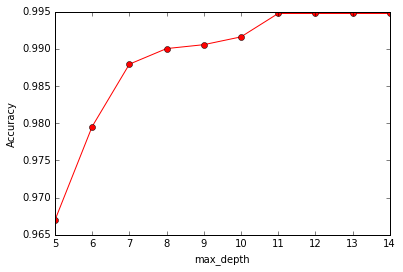

In [96]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 3
n_folds = 5
r_verbose = True

acs = []
for i in range(5, 15):
    max_depth = i

    feature_list = range(X.shape[1])
    root = fit(X, y, feature_list, min_amt=min_amt, max_depth=max_depth)

    predicted = np.apply_along_axis(predict, 1, X, root)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(5, 15)], acs, 'ro-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

In [129]:
def rf_fit(X, y, min_amt=0, max_depth=0, tree_amt=15, feature_size=0.1, voting=None):
    forest = random_forest(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)
    W = np.ones([len(forest), 1])
    if voting == 'adaboost':
        W = adaboost(X, y, forest)        
    return forest, W

In [130]:
# random forest
def random_forest(X, y, min_amt=0, max_depth=0, tree_amt=15, feature_size=0.1):
    forest = []
    feature_amt = int(math.ceil(X.shape[1] * feature_size))
    for i in range(tree_amt):
        m = resample(np.array(range(X.shape[0])))
        n = resample(np.array(range(X.shape[1])), replace=False, n_samples=feature_amt)
        X_s = X[m]
        y_s = y[m]
        
        root = fit(X_s, y_s, list(n), min_amt=min_amt, max_depth=max_depth)
        forest.append(root)
    return forest

In [131]:
def adaboost(X, y, forest):
    alpha = (1. / X.shape[0]) * np.ones([X.shape[0], 1])
    W = []
    for i in range(len(forest)):
        predicted = np.apply_along_axis(predict, 1, X, forest[i])
        if predicted.ndim == 1:
            predicted = np.expand_dims(predicted, axis=1)
            
        W.append(cal_w(predicted, y, alpha))
        alpha = cal_alpha(predicted, y, alpha, W[i])
    
    W = np.expand_dims(np.array(W), axis=1)
    return W

In [132]:
def cal_alpha(X, y, alpha, w):
    alpha *= np.exp(w * (np.fabs(X - y) - 1.))
    return alpha

In [133]:
def cal_w(X, y, alpha):
    w_error = weighted_error(X, y, alpha)
    return math.log((1. - w_error) / w_error) / 2.

In [134]:
def weighted_error(X, y, alpha):
    return 1. * np.sum(alpha[X != y]) / np.sum(alpha)

In [135]:
def rf_predict(X, forest, voting=None, W=None):
    rf_predicted = np.zeros([X.shape[0], 1])
    for i in range(len(forest)):
        predicted = np.apply_along_axis(predict, 1, X, forest[i])
        if predicted.ndim == 1:
            predicted = np.expand_dims(predicted, axis=1)
        
        rf_predicted = np.append(rf_predicted, predicted, axis=1)
    
    rf_predicted = np.delete(rf_predicted, 0, axis=1)
    if voting == 'adaboost':
        return adaboost_voting(rf_predicted, W)
    
    return majority_voting(rf_predicted)

In [136]:
def majority_voting(X):
    v = ((np.sum(X, axis=1) >= 0) + 0.) * 2. - 1.
    return v

In [137]:
def adaboost_voting(X, W):
    v = ((np.dot(X, W) >= 0) + 0.) * 2. - 1.
    return v

In [138]:
# cross validation
def rf_cross_validation(X, y, min_amt=0, max_depth=0, tree_amt=15, \
                        feature_size=0.1, voting=None, n_folds=5, r_verbose=False):
    train_c_matrix = []
    train_total_accuracy = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    train_F1 = []
    
    test_c_matrix = []
    test_total_accuracy = []
    test_accuracy = []
    test_precision = []
    test_recall = []
    test_F1 = []
    
    train_idx, test_idx = K_Fold(y.shape[0], n_folds=n_folds, shuffle=True)
    
    for i in range(n_folds):
        X_train = X[train_idx[i]]
        X_test = X[test_idx[i]]
        
        # fit
        forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, \
                           feature_size=feature_size, voting=voting)

        # training & test error
        train_predicted = rf_predict(X_train, forest, voting=voting, W=W)
        tr_c_matrix, tr_total_accuracy, tr_accuracy, tr_precision, tr_recall, tr_F1 = \
        score(train_predicted, y[train_idx[i]])
        
        test_predicted = rf_predict(X_test, forest, voting=voting, W=W)
        t_c_matrix, t_total_accuracy, t_accuracy, t_precision, t_recall, t_F1 = \
        score(test_predicted, y[test_idx[i]])
        
        train_c_matrix.append(tr_c_matrix)
        train_total_accuracy.append(tr_total_accuracy)
        train_accuracy.append(tr_accuracy)
        train_precision.append(tr_precision)
        train_recall.append(tr_recall)
        train_F1.append(tr_F1)
        
        test_c_matrix.append(t_c_matrix)
        test_total_accuracy.append(t_total_accuracy)
        test_accuracy.append(t_accuracy)
        test_precision.append(t_precision)
        test_recall.append(t_recall)
        test_F1.append(t_F1)
        
    train_accuracy = np.array(train_accuracy).T
    train_precision = np.array(train_accuracy).T
    train_recall = np.array(train_recall).T
    train_F1 = np.array(train_F1).T
    
    test_accuracy = np.array(test_accuracy).T
    test_precision = np.array(test_accuracy).T
    test_recall = np.array(test_recall).T
    test_F1 = np.array(test_F1).T
    
    # average error
    train_total_accuracy_avg = np.mean(train_total_accuracy)
    train_accuracy_avg = np.mean(train_accuracy, axis=1)
    train_precision_avg = np.mean(train_accuracy, axis=1)
    train_recall_avg = np.mean(train_recall, axis=1)
    train_F1_avg = np.mean(train_F1, axis=1)
    
    test_total_accuracy_avg = np.mean(test_total_accuracy)
    test_accuracy_avg = np.mean(test_accuracy, axis=1)
    test_precision_avg = np.mean(test_accuracy, axis=1)
    test_recall_avg = np.mean(test_recall, axis=1)
    test_F1_avg = np.mean(test_F1, axis=1)

    if r_verbose:
        print '(average results) CROSS_VALIDATION (n_folds = %d):' % n_folds
        print 'train_c_matrix,',
        print 'train_accuracy_avg, train_precision_avg, train_recall_avg, train_F1_avg,',
        print 'train_total_accuracy_avg'
        for i in range(len(train_c_matrix)):
            print_c_matrix(train_c_matrix[i])
        print '\n'
        print_avg(train_accuracy_avg)
        print_avg(train_precision_avg)
        print_avg(train_recall_avg)
        print_avg(train_F1_avg)
        print '\n'
        print '%.3f' % train_total_accuracy_avg
        print '\n'
        print 'test_c_matrix,',
        print 'test_accuracy_avg, test_precision_avg, test_recall_avg, test_F1_avg,',
        print 'test_total_accuracy_avg'
        for i in range(len(test_c_matrix)):
            print_c_matrix(test_c_matrix[i])
        print '\n'
        print_avg(test_accuracy_avg)
        print_avg(test_precision_avg)
        print_avg(test_recall_avg)
        print_avg(test_F1_avg)
        print '\n'
        print '%.3f' % test_total_accuracy_avg
        print '\n'

In [139]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 3
tree_amt = 20
feature_size = 0.1
n_folds = 5
r_verbose = True


# cross validation
# start timing
start = time.time()

rf_cross_validation(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size, \
                    n_folds=n_folds, r_verbose=r_verbose)

# stop timing
stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration
print '\n\n'


# apply to all data
# start timing
start = time.time()

forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

# print the tree
for i in range(len(forest)):
    print '@@@@@@@@@@@@ printing tree start @@@@@@@@@@@@'
    print_decision_tree(forest[i], 0)
    print '@@@@@@@@@@@@ printing tree end @@@@@@@@@@@@'
    print '\n'

predicted = rf_predict(X, forest)
c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)
accuracy = np.array(accuracy).T
precision = np.array(accuracy).T
recall = np.array(recall).T
F1 = np.array(F1).T

print 'APPLY TO ALL DATA:'
print 'c_matrix,', 
print 'accuracy, precision, recall, F1,',
print 'total_accuracy'
print_c_matrix(c_matrix)
print '\n'
print_avg(accuracy)
print_avg(precision)
print_avg(recall)
print_avg(F1)
print '\n'
print '%.3f' % total_accuracy
print '\n'

# stop timing
stop = time.time()
duration = stop - start
print '\n'
print 'apply to all duration =', duration

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)
(average results) CROSS_VALIDATION (n_folds = 5):
train_c_matrix, train_accuracy_avg, train_precision_avg, train_recall_avg, train_F1_avg, train_total_accuracy_avg
550 & 30 \\ 
2 & 944 \\ 

554 & 30 \\ 
0 & 942 \\ 

546 & 31 \\ 
4 & 945 \\ 

567 & 32 \\ 
4 & 924 \\ 

558 & 34 \\ 
0 & 935 \\ 



0.978 & 0.978 \\ 
0.978 & 0.978 \\ 
0.946 & 0.998 \\ 
0.971 & 0.983 \\ 


0.978


test_c_matrix, test_accuracy_avg, test_precision_avg, test_recall_avg, test_F1_avg, test_total_accuracy_avg
148 & 5 \\ 
1 & 228 \\ 

145 & 4 \\ 
1 & 232 \\ 

146 & 10 \\ 
0 & 226 \\ 

120 & 14 \\ 
0 & 247 \\ 

127 & 14 \\ 
0 & 240 \\ 



0.974 & 0.974 \\ 
0.974 & 0.974 \\ 
0.935 & 0.998 \\ 
0.965 & 0.980 \\ 


0.974


cross_validation duration = 73.511726141



@@@@@@@@@@@@ printing tree start @@@@@@@@@@@@
		depth = 2 (LEAF result = 1)
	depth = 1 (fid=18, th=37.5)
			depth = 3 (LEAF result = -1)
		depth = 2 (fid=20, th=311.5)
			depth = 3 (LEAF result = -1)
depth = 0 (fid=4

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


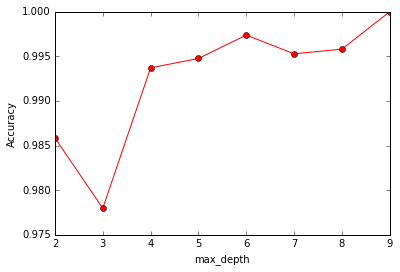

In [86]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
# max_depth = 3
tree_amt = 20
feature_size = 0.2
n_folds = 5
r_verbose = True

acs = []
for i in range(2, 10):
    max_depth = i

    forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

    predicted = rf_predict(X, forest)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(2, 10)], acs, 'ro-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


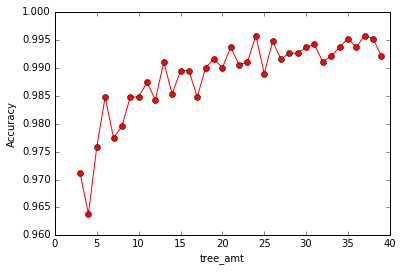

In [87]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 4
# tree_amt = 20
feature_size = 0.2
n_folds = 5
r_verbose = True

acs = []
for i in range(3, 40):
    tree_amt = i

    forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

    predicted = rf_predict(X, forest)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(3, 40)], acs, 'ro-')
plt.xlabel('tree_amt')
plt.ylabel('Accuracy')
plt.show()

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


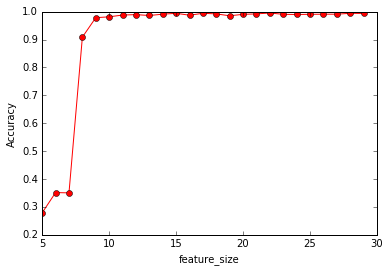

In [92]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 4
tree_amt = 20
# feature_size = 0.05
n_folds = 5
r_verbose = True

acs = []
for i in range(5, 30):
    feature_size = i * 0.01

    forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

    predicted = rf_predict(X, forest)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(5, 30)], acs, 'ro-')
plt.xlabel('feature_size')
plt.ylabel('Accuracy')
plt.show()

In [140]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 3
tree_amt = 20
feature_size = 0.1
voting = 'adaboost'
n_folds = 5
r_verbose = True


# cross validation
# start timing
start = time.time()

rf_cross_validation(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, \
                    feature_size=feature_size, voting=voting, \
                    n_folds=n_folds, r_verbose=r_verbose)

# stop timing
stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration
print '\n\n'


# apply to all data
# start timing
start = time.time()

forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

# print the tree
for i in range(len(forest)):
    print '@@@@@@@@@@@@ printing tree start @@@@@@@@@@@@'
    print_decision_tree(forest[i], 0)
    print '@@@@@@@@@@@@ printing tree end @@@@@@@@@@@@'
    print '\n'

predicted = rf_predict(X, forest, voting=voting, W=W)
c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)
accuracy = np.array(accuracy).T
precision = np.array(accuracy).T
recall = np.array(recall).T
F1 = np.array(F1).T

print 'APPLY TO ALL DATA:'
print 'c_matrix,', 
print 'accuracy, precision, recall, F1,',
print 'total_accuracy'
print_c_matrix(c_matrix)
print '\n'
print_avg(accuracy)
print_avg(precision)
print_avg(recall)
print_avg(F1)
print '\n'
print '%.3f' % total_accuracy
print '\n'

# stop timing
stop = time.time()
duration = stop - start
print '\n'
print 'apply to all duration =', duration

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)
(average results) CROSS_VALIDATION (n_folds = 5):
train_c_matrix, train_accuracy_avg, train_precision_avg, train_recall_avg, train_F1_avg, train_total_accuracy_avg
574 & 15 \\ 
3 & 934 \\ 

577 & 15 \\ 
3 & 931 \\ 

539 & 45 \\ 
7 & 935 \\ 

569 & 14 \\ 
4 & 940 \\ 

560 & 24 \\ 
14 & 929 \\ 



0.981 & 0.981 \\ 
0.981 & 0.981 \\ 
0.961 & 0.993 \\ 
0.975 & 0.985 \\ 


0.981


test_c_matrix, test_accuracy_avg, test_precision_avg, test_recall_avg, test_F1_avg, test_total_accuracy_avg
142 & 2 \\ 
1 & 237 \\ 

137 & 4 \\ 
1 & 240 \\ 

131 & 18 \\ 
2 & 231 \\ 

145 & 5 \\ 
1 & 230 \\ 

144 & 5 \\ 
2 & 230 \\ 



0.979 & 0.979 \\ 
0.979 & 0.979 \\ 
0.954 & 0.994 \\ 
0.971 & 0.983 \\ 


0.979


cross_validation duration = 78.3030798435



@@@@@@@@@@@@ printing tree start @@@@@@@@@@@@
			depth = 3 (LEAF result = -1)
		depth = 2 (fid=41, th=430.5)
			depth = 3 (LEAF result = 1)
	depth = 1 (fid=21, th=2.5)
			depth = 3 (LEAF result = -1)
		depth = 2 (fid

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


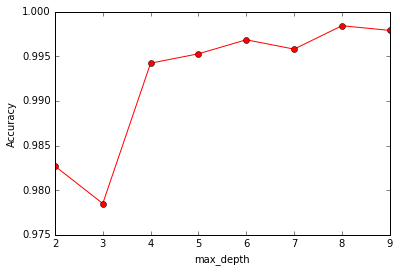

In [94]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
# max_depth = 3
tree_amt = 20
feature_size = 0.2
voting = 'adaboost'
n_folds = 5
r_verbose = True

acs = []
for i in range(2, 10):
    max_depth = i

    forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

    predicted = rf_predict(X, forest, voting=voting, W=W)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(2, 10)], acs, 'ro-')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


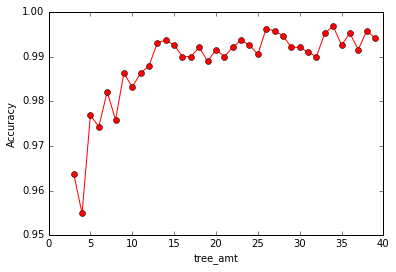

In [95]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 5
max_depth = 4
# tree_amt = 20
feature_size = 0.2
voting = 'adaboost'
n_folds = 5
r_verbose = True

acs = []
for i in range(3, 40):
    tree_amt = i

    forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

    predicted = rf_predict(X, forest, voting=voting, W=W)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(3, 40)], acs, 'ro-')
plt.xlabel('tree_amt')
plt.ylabel('Accuracy')
plt.show()

(1908, 90) (1908, 1)
(1908, 70) (1908, 1)


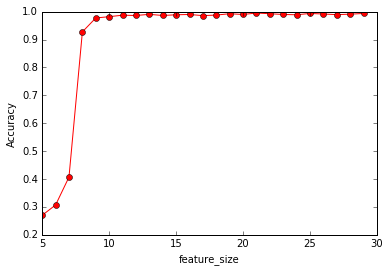

In [110]:
# read file
X, y = retrieve_data()


# parameters
min_amt = 0
max_depth = 4
tree_amt = 20
# feature_size = 0.05
voting = 'adaboost'
n_folds = 5
r_verbose = True

acs = []
for i in range(5, 30):
    feature_size = i * 0.01

    forest, W = rf_fit(X, y, min_amt=min_amt, max_depth=max_depth, tree_amt=tree_amt, feature_size=feature_size)

    predicted = rf_predict(X, forest, voting=voting, W=W)
    c_matrix, total_accuracy, accuracy, precision, recall, F1 = score(predicted, y)

    acs.append(total_accuracy)

plt.plot([x for x in range(5, 30)], acs, 'ro-')
plt.xlabel('feature_size')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

X, y = retrieve_data(False)
Z_temp = X
start = time.time()

k_fold = KFold(y.shape[0], n_folds=5)

svc = SVC(C=1e-5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=4, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=10, shrinking=True,
    tol=0.1, verbose=False)
score_svc = []
for k, (train_index, test_index) in enumerate(k_fold):
    svc.fit(Z_temp[train_index], y[train_index])
    score_svc.append(svc.score(Z_temp[test_index], y[test_index]))
print 'SVC Accuracy: ', np.mean(score_svc)

stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration

In [ ]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
clf_GNB = GaussianNB()
clf_GNB.fit(Z_temp, y)
score_GNB = []
for k, (train_index, test_index) in enumerate(k_fold):
    clf_GNB.fit(Z_temp[train_index], y[train_index])
    score_GNB.append(clf_GNB.score(Z_temp[test_index], y[test_index]))
print 'GaussianNB Accuracy: ', np.mean(score_GNB)

stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration

In [ ]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
rfc = RandomForestClassifier(n_estimators=15, max_features=7, max_depth=3)
rfc.fit(Z_temp, y)
score_RF = []
for k, (train_index, test_index) in enumerate(k_fold):
    rfc.fit(Z_temp[train_index], y[train_index])
    score_RF.append(rfc.score(Z_temp[test_index], y[test_index]))
print 'RF Accuracy: ', np.mean(score_RF)

stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration

In [ ]:
from sklearn.tree import DecisionTreeRegressor

start = time.time()
dtr = DecisionTreeRegressor(max_depth=10)
dtr.fit(Z_temp, y)
score_DT = []
for k, (train_index, test_index) in enumerate(k_fold):
    dtr.fit(Z_temp[train_index], y[train_index])
    score_DT.append(dtr.score(Z_temp[test_index], y[test_index]))
print 'DTs Accuracy:', np.mean(score_DT)

stop = time.time()
duration = stop - start
print 'cross_validation duration =', duration